# MIMIC - sigmoid

"MIMIC is designed to analyze the news at- tributes. Enlightened by ..., we employ a deep neural network as the teacher, and use a shallow model as the student to emulate the teacher’s performance for better explainability. Basically, the overall idea is to mimic the performance of neural networks with tree ensemble models, so that we can keep the good performance from neural networks and good explainability from tree ensemble models simultaneously." (Yang, Pentyala, Mohseni, Du, Yuan, Linder, Ragan, Ji & Hu, 2019)

Yang, F., Pentyala, S. K., Mohseni, S., Du, M., Yuan, H., Linder, R., Ragan, E. D., Ji, S. & Hu, X. (2019). XFake: explainable fake news detector with visualizations. In The World Wide Web Conference (pp. 3600-3604).

# Teacher model

## Import packages

In [1]:
import re
import os
import spacy
import pandas as pd
import numpy as np
from unidecode import unidecode
import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

In [2]:
# import English language model
nlp = spacy.load("/opt/anaconda3/lib/python3.8/site-packages/en_core_web_sm/en_core_web_sm-2.3.1")

## Import data

In [3]:
# import data
df = pd.read_table("data.csv", delimiter = ",",)

In [4]:
# select only what we need
df = df[['label', 'statement', 'speaker', 'subject', 'context']]

In [5]:
# show dataframe
df.head()

,label,statement,speaker,subject,context
0,false,Says the Annies List political group supports ...,dwayne-bohac,abortion,a mailer
1,half-true,When did the decline of coal start? It started...,scott-surovell,"energy,history,job-accomplishments",a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,foreign-policy,Denver
3,false,Health care reform legislation is likely to ma...,blog-posting,health-care,a news release
4,half-true,The economic turnaround started at the end of ...,charlie-crist,"economy,jobs",an interview on CNN


In [6]:
# labels to binary (int)
df['label'] = df['label'].replace(['mostly-true','half-true', 'barely-true', 'no-flip', 'half-flip', 'true'], 1)
df['label'] = df['label'].replace(['mostly-false','pants-fire', 'full-flop', 'false'], 0)
df['label'] = df['label'].astype('int')

In [7]:
# drop nan
df = df.dropna()

In [8]:
# show dataframe
df.head()

,label,statement,speaker,subject,context
0,0,Says the Annies List political group supports ...,dwayne-bohac,abortion,a mailer
1,1,When did the decline of coal start? It started...,scott-surovell,"energy,history,job-accomplishments",a floor speech.
2,1,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,foreign-policy,Denver
3,0,Health care reform legislation is likely to ma...,blog-posting,health-care,a news release
4,1,The economic turnaround started at the end of ...,charlie-crist,"economy,jobs",an interview on CNN


## Pre-processing statement and context

* Remove extra whitespaces
* Convert accented characters to ASCII characters
* Expand contractions
* Expand abbreviations
* Remove special characters
* Remove numbers
* Lowercase all texts
* Remove stopwords
* Lemmatization

In [9]:
# Remove extra whitespaces
df['statement'] = [' '.join(statement.split()) for statement in df['statement']]
df['context'] = [' '.join(context.split()) for context in df['context']]

In [10]:
# Convert accented characters to ASCII characters
df['statement'] = [unidecode(statement) for statement in df['statement']]
df['context'] = [unidecode(context) for context in df['context']]

In [11]:
# Expand contractions

def expand_contractions(text):
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    text = re.sub(r"(\s|^)'(aight|cause)(\s|$)", '\g<1>\g<2>\g<3>', text, flags = flags)
    text = re.sub(r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>', text, flags = flags)
    text = re.sub(r"(\s|^)ol'(\s|$)", '\g<1>old\g<2>', text, flags = flags)
    
    ## expand words without
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)
    
    return text

df['statement'] = [expand_contractions(statement) for statement in df['statement']]
df['context'] = [expand_contractions(context) for context in df['context']]

In [12]:
# Expand abbreviations

abbr = {'u.n.': 'united nations',
        'a.m.': 'before midday',
        'n.y.': 'new york',
        'e.u.': 'european union',
        'u.s.': 'united states',
        'u.k.': 'united kingdom',
        'd.c.': 'district columbia',
        'a.k.a.': 'also known as',
        'r.i.p.': 'rest in peace',
        'n.h.': 'new hampshire',
        'r.i.': 'rhode island',
        's.c.': 'south carolina',
        
        'gop': 'the republican party',
        'usa': 'united states of america',
        'nato': 'north atlantic treaty organization',
        'epa': 'environmental protection agency',
                 
        'rep.': 'representative',
        'reps.': 'representatives',
        'dem.': 'democrat',
        'tenn.': 'tennessee',
        'capt': 'captain',
        'gov.': 'government',
        'sen.': 'senator',
        'mr.': 'mister',
        'ok': 'okay',
        'gen.': 'general',
        'jr.': 'junior',
       }

def expand_abbreviations(text):

    for key, value in abbr.items():
        if key in text:
            text = text.replace(key, value)
    
    return text

df['statement'] = [expand_abbreviations(statement) for statement in df['statement']]
df['context'] = [expand_abbreviations(context) for context in df['context']]

In [13]:
# Remove special characters
df['statement'] = [re.sub(r"[^a-zA-Z0-9]+", ' ', statement) for statement in df['statement']]
df['context'] = [re.sub(r"[^a-zA-Z0-9]+", ' ', context) for context in df['context']]

In [14]:
# Remove numbers
df['statement'] = [re.sub(" \d+", " ", statement) for statement in df['statement']]
df['context'] = [re.sub(" \d+", " ", context) for context in df['context']]

In [15]:
# Lowercase all texts
df['statement'] = [statement.lower() for statement in df['statement']]
df['context'] = [context.lower() for context in df['context']]

In [16]:
# lemmatization
df['statement'] = [" ".join([token.lemma_ for token in nlp(statement)]) for statement in df['statement']]
df['context'] = [" ".join([token.lemma_ for token in nlp(context)]) for context in df['context']]

In [17]:
df.head()

,label,statement,speaker,subject,context
0,0,say the annie list political group support thi...,dwayne-bohac,abortion,a mailer
1,1,when do the decline of coal start -PRON- start...,scott-surovell,"energy,history,job-accomplishments",a floor speech
2,1,hillary clinton agree with john mccain by vote...,barack-obama,foreign-policy,denver
3,0,health care reform legislation be likely to ma...,blog-posting,health-care,a news release
4,1,the economic turnaround start at the end of -P...,charlie-crist,"economy,jobs",an interview on cnn


## Pre-processing speaker and subject

In [18]:
# speaker: replace hyphen with space
df['speaker'] = [speaker.replace("-", " ") for speaker in df['speaker']]

In [19]:
# subject: replace hyphen and comma with space
df['subject'] = [subject.replace("-", " ").replace(",", " ") for subject in df['subject']]

In [20]:
df.head()

,label,statement,speaker,subject,context
0,0,say the annie list political group support thi...,dwayne bohac,abortion,a mailer
1,1,when do the decline of coal start -PRON- start...,scott surovell,energy history job accomplishments,a floor speech
2,1,hillary clinton agree with john mccain by vote...,barack obama,foreign policy,denver
3,0,health care reform legislation be likely to ma...,blog posting,health care,a news release
4,1,the economic turnaround start at the end of -P...,charlie crist,economy jobs,an interview on cnn


## Tokenize

In [21]:
output_dim = 100
maxlen = 100

In [22]:
embeddings_index = {}

f = open(os.path.join('glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

In [23]:
# statement

statement_text = ''

for i in df['statement']:
    statement_text += i
    
max_words = len(set(statement_text.split()))

statement_texts = df['statement']

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(statement_texts)
statement_word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(statement_texts)
statement_data = pad_sequences(sequences, maxlen = maxlen)

statement_embedding_matrix = np.zeros((len(statement_word_index) + 1, output_dim))

for word, i in statement_word_index.items():
    statement_embedding_vector = embeddings_index.get(word)
    if statement_embedding_vector is not None:
        statement_embedding_matrix[i] = statement_embedding_vector

In [24]:
# speaker

speaker_text = ''

for i in df['speaker']:
    speaker_text += i
    
max_words = len(set(speaker_text.split()))

speaker_texts = df['speaker']

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(speaker_texts)
speaker_word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(speaker_texts)
speaker_data = pad_sequences(sequences, maxlen = maxlen)

speaker_embedding_matrix = np.zeros((len(speaker_word_index) + 1, output_dim))

for word, i in speaker_word_index.items():
    speaker_embedding_vector = embeddings_index.get(word)
    if speaker_embedding_vector is not None:
        speaker_embedding_matrix[i] = speaker_embedding_vector

In [25]:
# subject

subject_text = ''

for i in df['subject']:
    subject_text += i
    
max_words = len(set(subject_text.split()))

subject_texts = df['subject']

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(subject_texts)
subject_word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(subject_texts)
subject_data = pad_sequences(sequences, maxlen = maxlen)

subject_embedding_matrix = np.zeros((len(subject_word_index) + 1, output_dim))

for word, i in subject_word_index.items():
    subject_embedding_vector = embeddings_index.get(word)
    if subject_embedding_vector is not None:
        subject_embedding_matrix[i] = subject_embedding_vector

In [26]:
# context

context_text = ''

for i in df['context']:
    context_text += i
    
max_words = len(set(context_text.split()))

context_texts = df['context']

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(context_texts)
context_word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(context_texts)
context_data = pad_sequences(sequences, maxlen = maxlen)

context_embedding_matrix = np.zeros((len(context_word_index) + 1, output_dim))

for word, i in context_word_index.items():
    context_embedding_vector = embeddings_index.get(word)
    if context_embedding_vector is not None:
        context_embedding_matrix[i] = context_embedding_vector

## Model parameters

In [27]:
# convolution
filters = 4
kernel_size = 4

In [28]:
# lstm
units_lstm = 128

In [29]:
# dense
units_dense = 10

In [30]:
# model
epochs = 2
batch_size = 256

## Build the model

### Statement layers

In [31]:
# input
statement_input = keras.Input(shape = (None,), name = "statement_input")

# embedding
statement_features = layers.Embedding(len(statement_word_index) + 1, output_dim = output_dim, weights = [statement_embedding_matrix], trainable = False,name = "statement_embedding")(statement_input)

# convolution
statement_features = layers.Conv1D(filters, kernel_size, strides = 1, padding = 'same', activation='relu', name = "statement_convolution")(statement_features)
    
# maxpooling
statement_features = layers.MaxPooling1D(strides = 1, padding = 'same', name = "statement_maxpooling")(statement_features)

### Speaker layers

In [32]:
# input
speaker_input = keras.Input(shape = (None,), name = "speaker_input")

# embedding
speaker_features = layers.Embedding(len(speaker_word_index) + 1, output_dim = output_dim, weights = [speaker_embedding_matrix], trainable = False, name = "speaker_embedding")(speaker_input)

### Subject layers

In [33]:
# input
subject_input = keras.Input(shape = (None,), name = "subject_input")

# embedding
subject_features = layers.Embedding(len(subject_word_index) + 1, output_dim = output_dim, weights = [subject_embedding_matrix], trainable = False, name = "subject_embedding")(subject_input)

# Bi-LSTM
subject_features = layers.Bidirectional(layers.LSTM(units_lstm, name = "statement_bi-lstm", return_sequences = True))(subject_features)

### Context layers

In [34]:
# input
context_input = keras.Input(shape = (None,), name = "context_input")

# embedding
context_features = layers.Embedding(len(context_word_index) + 1, output_dim = output_dim, weights = [context_embedding_matrix], trainable = False, name = "context_embedding")(context_input)

# Bi-LSTM
context_features = layers.Bidirectional(layers.LSTM(units_lstm, name = "context_bi-lstm", return_sequences = True))(context_features)

### Merged layers

In [35]:
# input
merged = layers.concatenate([statement_features, speaker_features, subject_features, context_features], name = "merge")

In [36]:
# fully connected layer
fully_connetcted = layers.Dense(units_dense, activation='relu', name = "fully_connected")(merged)

In [37]:
# softmax layer
sigmoid = layers.Dense(2, activation='sigmoid', name = "sigmoid")(fully_connetcted)

### Build model and display

In [38]:
# build model
model = keras.Model(
    inputs = [statement_input, speaker_input, subject_input, context_input],
    outputs = [sigmoid],
)

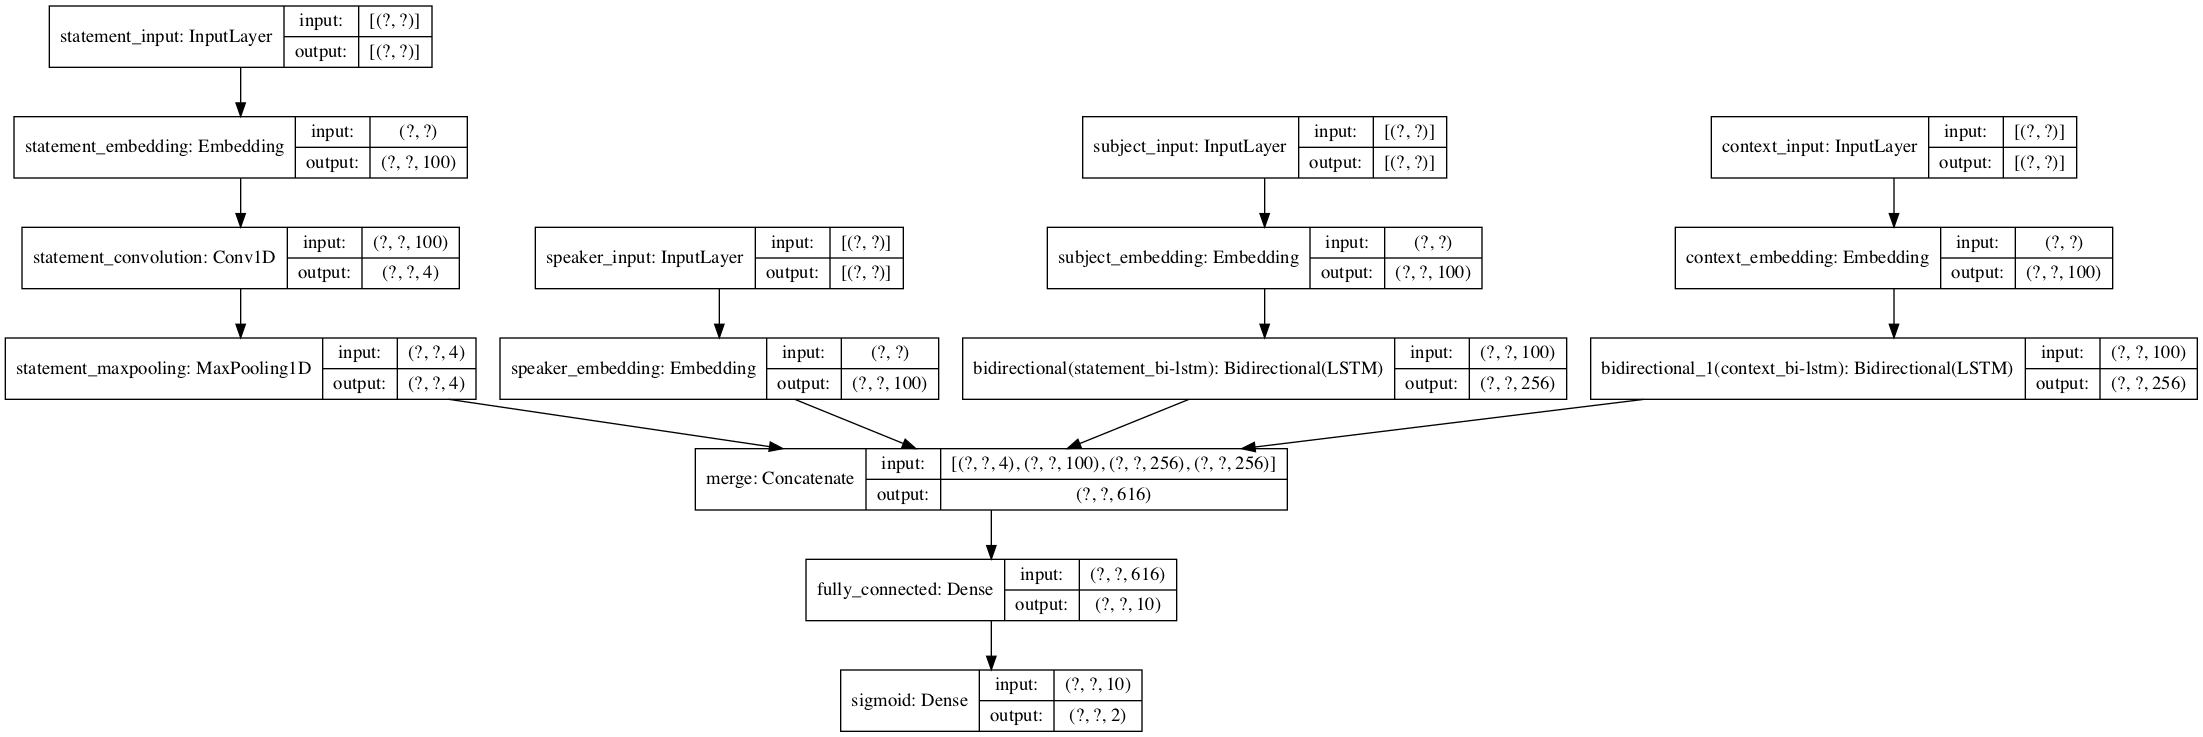

In [39]:
# show model
keras.utils.plot_model(model, "multi_input_model.png", show_shapes = True)

### Compile and run model

In [40]:
# compile model
model.compile(optimizer = 'sgd', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
statement_input (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
statement_embedding (Embedding) (None, None, 100)    997000      statement_input[0][0]            
__________________________________________________________________________________________________
subject_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      [(None, None)]       0                                            
_______________________________________________________________________________________

In [42]:
# trainingsdata
statement_data_train = statement_data[:int(12820*0.7)]
speaker_data_train = speaker_data[:int(12820*0.7)]
subject_data_train = subject_data[:int(12820*0.7)]
context_data_train = context_data[:int(12820*0.7)]
label_data_train = df['label'][:int(12820*0.7)]
#label_data_train = to_categorical(label_data_train)

# test data
statement_data_test = statement_data[int(12820*0.7):]
speaker_data_test = speaker_data[int(12820*0.7):]
subject_data_test = subject_data[int(12820*0.7):]
context_data_test = context_data[int(12820*0.7):]
label_data_test = df['label'][int(12820*0.7):]
#label_data_test = to_categorical(label_data_test)

In [43]:
model.fit(
    {"statement_input": statement_data_train,
    "speaker_input": speaker_data_train,
     "subject_input": subject_data_train,
     "context_input": context_data_train},
    {'sigmoid': label_data_train},
    validation_data = (
        [statement_data_test, speaker_data_test, subject_data_test, context_data_test], 
        label_data_test),
    epochs = epochs,
    batch_size = batch_size
)

Epoch 1/2


ValueError: in user code:

    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4823 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/envs/fake_news/lib/python3.8/site-packages/tensorflow/python/ops/nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 100, 2) vs (None, 1))


# Student model

...